## L1 regularization on linear scale

For the linear scale it should be enough to just specify the priors in the parameters table of the petab problem. For the `log10` scale this should also suffice, but we need to think whether we want to have priors on the linear scale or on the original parameter scale (`log10`).

For the `log10_shift` and the `logicle` scale this is a little bit more involved, since we cannot specify those scales in the parameters table.

In [1]:
import libsbml
import importlib
import os
import sys
import shutil
import pandas as pd



import amici
import matplotlib.pyplot as plt
import numpy as np 
import petab 
from petab.C import *

import pypesto
import pypesto.optimize as optimize
import pypesto.petab
import pypesto.visualize as visualize
import pypesto.objective

In [3]:
# create parameter table with priors

param_scale = 'lin'

parameter_df = pd.DataFrame(
    data={
        PARAMETER_ID: ['k1', 'k2', 'k3', 'sd_observed_B'],
        PARAMETER_SCALE: [param_scale] * 4,
        LOWER_BOUND: [0] * 4,
        UPPER_BOUND: [1000] * 4,
        NOMINAL_VALUE: [0.2, 0.1, 0.0, 0.15],
        ESTIMATE: [1, 1, 1, 0],
        'initializationPriorType': ['laplace', 'laplace', 'laplace', None],
        'initializationPriorParameters': ['0; 1', '0; 1', '0; 1', None],
        'objectivePriorType': ['laplace', 'laplace', 'laplace', None],
        'objectivePriorParameters': ['0; 1', '0; 1', '0; 1', None]

    }
).set_index(PARAMETER_ID)

petab.write_parameter_df(parameter_df, "petab/"+param_scale+"/parameters.tsv")

Maybe modifications by hand are needed afterwards to get the `PriorParameters` of the form `location;scale`.

In [ ]:
model_name= "Spoegler_conversionReaction"


# the yaml file includes all important links to other files
yaml_config ="petab/"+param_scale+"/"+model_name+".yaml"
# create a petab problem
petab_problem = petab.Problem.from_yaml(yaml_config)

# or create from folder (did not work)
# petab_problem = petab.Problem.from_folder("petab/"+param_scale)

# import to amici
importer = pypesto.petab.PetabImporter(petab_problem)
importer.compile_model()

model = importer.create_model()

In [5]:
# initialize solver and options
solver = importer.create_solver(model)

# enable sensitivities
solver.setSensitivityOrder(amici.SensitivityOrder_first)       
solver.setSensitivityMethod(amici.SensitivityMethod_forward)  
model.requireSensitivitiesForAllParameters()     

In [6]:
# objective function
obj = importer.create_objective()

Using existing amici model in folder /home/vinc777/python_projects/moses/spoegler_model_reduction/l1_regularization/amici_models/Sp_gler_ConversionReaction.


In [42]:
print('optimal x = ', petab_problem.x_nominal)
print('optimal lh value', obj(petab_problem.x_nominal[0:3]))

optimal x =  [0.2, 0.1, 0.0, 0.15]
optimal lh value -3.418410576784529


In [9]:
# create optimizer object
optimizer = optimize.ScipyOptimizer()

# create problem object
problem = importer.create_problem(obj)

# do the optimization
n_starts = 100

result = optimize.minimize(problem=problem, optimizer=optimizer, n_starts=n_starts, filename=None)

  7%|▋         | 7/100 [00:09<02:01,  1.31s/it][Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 37.2362, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 37.236188:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 37.2362, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 37.236188:
AMICI failed to integrate the forward problem

 31%|███       | 31/100 [00:36<01:30,  1.31s/it][Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES in function CVode : At t = 45.2671, mxstep steps taken before reaching tout. 
[Warning] AMICI:simulation: AMICI forward simulation failed at t = 45.267120:
AMICI failed to integrate the forward problem

[Warning] AMICI:CVODES:CVode:TOO_MUCH_WORK: AMICI ERROR: in module CVODES 

In [12]:
# print results
best_result=result.optimize_result.as_list("x")[0]["x"]
print('best parameter: ', best_result)
print('best likelihood value: ', problem.objective(best_result[0:3]))

best parameter:  [0.26581879 0.06621133 0.00162104 0.15      ]
best likelihood value:  -2.2992910974502045


<AxesSubplot:title={'center':'Waterfall plot'}, xlabel='Ordered optimizer run', ylabel='Function value'>

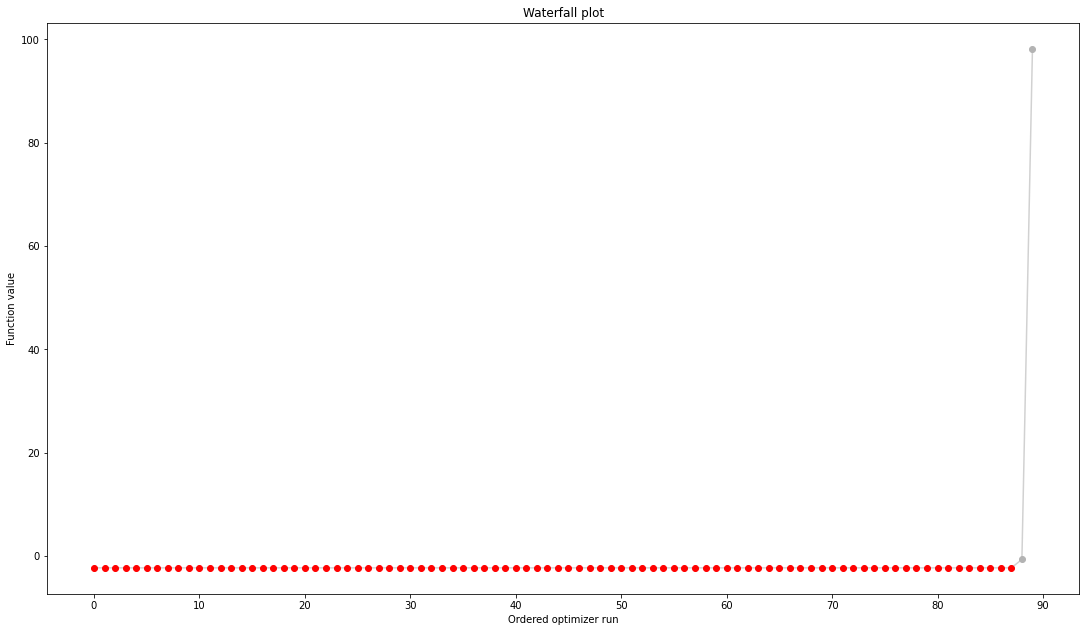

In [15]:
# waterfall plot
fvals = result.optimize_result.get_for_key("fval")
fval = np.array(fvals)
fval=fval[fval < 1e2]
visualize.waterfall_lowlevel(fval, scale_y='lin')

THis approach with specifying the prior using the parameter table is not realy feasible if we want to compute a regularization path for different values of the prior parameters, so for different regularization strengths. Because we would need a new parameter table every time. 
A better approach can be to get the normal objecitve function, which is the log-likelihood (negative?) and then add the regularization term, which was computed manually, by the `AggregatedObjective` function from pypesto.

Or another approach could be to create a prior dictionary using pypesto `get_parameter_prior_dict` and then `objective.NegLogParameterPriors`. --> This is the same I guess

In [94]:
def make_prior(petab_problem, strength, scale='lin'): 
  prior_list = []

  for i in range(len(petab_problem.get_model_parameters())):
    priorType = 'laplace'
    priorParameters = [0, 1/strength]
    priorScale = scale
    prior = pypesto.objective.get_parameter_prior_dict(i, priorType, priorParameters, priorScale)
    prior_list.append(prior)

  return pypesto.objective.NegLogParameterPriors(prior_list)

In [95]:
model_name= "Spoegler_conversionReaction"
param_scale= 'lin'

# the yaml file includes all important links to other files
yaml_config ="petab/"+'lin2'+"/"+model_name+".yaml"
# create a petab problem
petab_problem2 = petab.Problem.from_yaml(yaml_config)


# import to amici
importer2 = pypesto.petab.PetabImporter(petab_problem2)
#importer.compile_model()

model2 = importer2.create_model()

Using existing amici model in folder /home/vinc777/python_projects/moses/spoegler_model_reduction/l1_regularization/amici_models/Sp_gler_ConversionReaction.


In [92]:
len(petab_problem2.get_model_parameters())

3

In [96]:
# initialize solver and options
solver = importer.create_solver(model2)

# enable sensitivities
solver.setSensitivityOrder(amici.SensitivityOrder_first)       
solver.setSensitivityMethod(amici.SensitivityMethod_forward)  
model2.requireSensitivitiesForAllParameters()  

In [97]:
# objective function
obj2 = importer.create_objective()

neg_log_likelihood = obj2

Using existing amici model in folder /home/vinc777/python_projects/moses/spoegler_model_reduction/l1_regularization/amici_models/Sp_gler_ConversionReaction.


In [99]:
strength = 1

neg_log_prior = make_prior(petab_problem2, strength)

neg_log_posterior = pypesto.objective.AggregatedObjective([neg_log_likelihood, neg_log_prior])

print('optimal x = ', petab_problem2.x_nominal)
print('optimal lh value', neg_log_posterior(petab_problem2.x_nominal))

optimal x =  [0.2, 0.1, 0.0, 0.15]
optimal lh value -1.0389690351046932


This gives the same value as the `problem.objective` from the first appraoch.

`problem2.objective()' also gives the same value as before and as the neg_log_posterior.

In [ ]:
# lb = np.array(petab_problem2.parameter_df['lowerBound'][0:3])
# ub = np.array(petab_problem2.parameter_df['upperBound'][0:3])

# create optimizer object
optimizer = optimize.ScipyOptimizer()

# create problem object
problem2 = importer2.create_problem(objective=neg_log_posterior)

# do the optimization
n_starts = 100

result2 = optimize.minimize(problem=problem2, optimizer=optimizer, n_starts=n_starts, filename=None)

## Question
If I just use `pypesto.Problem(obj, lb, ub)` then the optimization fails due to some broadcasting error. (cannot broadcast together shape (4,) and (3,)) But I don't get where this comes from since th eobjective just needs 3 arguments and in the petab file the forth pameter is fixed and should not be estimated.
It works with the above and still does what I want but interesting though.

In [72]:
print('result', obj, '=', result2)
print('best result = ', result2.optimize_result.as_list('x')[0]['x'])

# print results
best_result2=result2.optimize_result.as_list("x")[0]["x"]
print('best parameter: ', best_result2)
print('best likelihood value: ', problem2.objective(best_result2[0:3]))

result <pypesto.objective.amici.AmiciObjective object at 0x7f6ad147feb0> = <pypesto.result.result.Result object at 0x7f6ade6a7070>
best result =  [0.26581895 0.06621138 0.00162107 0.15      ]
best parameter:  [0.26581895 0.06621138 0.00162107 0.15      ]
best likelihood value:  -2.299291061952246


<AxesSubplot:title={'center':'Waterfall plot'}, xlabel='Ordered optimizer run', ylabel='Function value'>

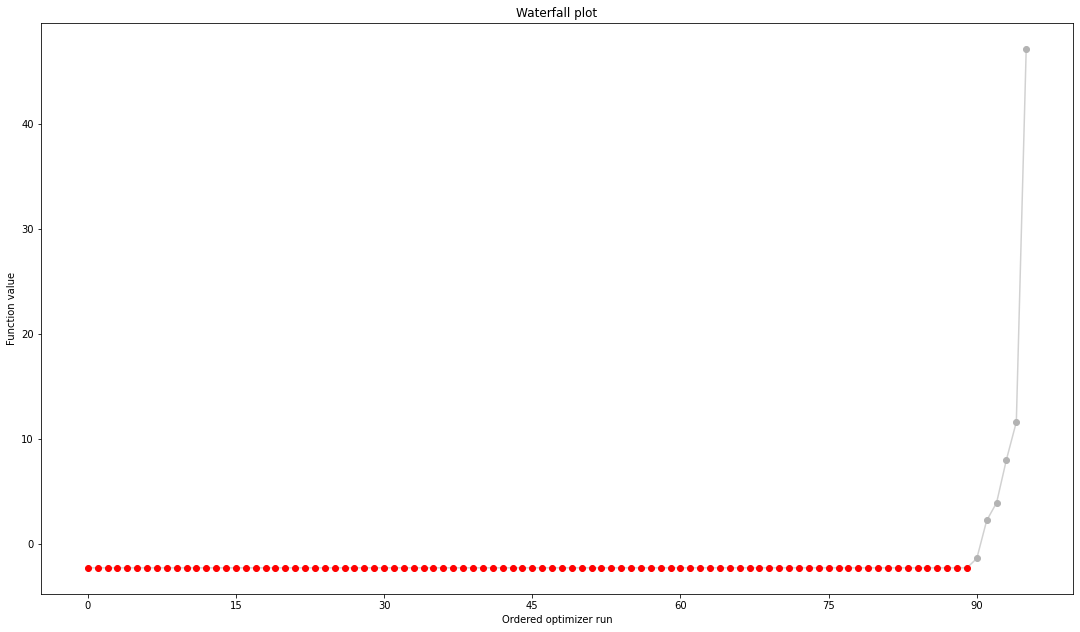

In [75]:
# waterfall plot
fvals = result2.optimize_result.get_for_key("fval")
fval = np.array(fvals)
fval=fval[fval < 1e2]
visualize.waterfall_lowlevel(fval, scale_y='lin')